<h3> Introduction to Naive Bayes </h3>

A naive bayes classifier assigns labels to observations using a process based on Bayes' theorem. The important element of the theorem is updating the probability of an event based on the known prior events. For instance, if all vehicles with 2 wheels are motorcycles, then we can update the probability that an unknown vehicle is a motorcycle given whether we know it has two wheels. In the case of a classification algorithm, the prosterior probabilities in question are the likelihoods that a given observation belongs to each class. Using the known prior events to update the probability of each class, the algorithm would take whichever class label had the highest likelihood and assign that to the data point in question. 

A naive Bayes classifier has several variants based on the types of features being used to predict class labels.
- Gaussian: If the predictors are continuous, then we likely will not have exact probabilities for the given input point (as no other point may have the exact same value for all input features). As such, a different approach is required, where it is assumed that the continuous attributes are normally distributed. Then, for a given point that needs to be classified, we can express the probability of it belonging to a certain class as the likelihood that the point came from each class's distribution. This is relatively easy, as we can simply find the likelihood that the point was generated by each class distribution, and assign the most likely one as the label.
- Multinomial: This method is preferred when the predictors are generated by a multinomial distribution, meaning they are discrete, with more than 2 levels. Labels would be assigned to new observations based on the conditional probability of observing the point's attributes given that it came from each class (which can be calculated again using Baye's theorem since the attributes are discirete).
- Bernoulli Naive Bayes: The Bernoulli method is preferred when the predictors are binary, meaning they are discrete but only have two values they can take. This is calculated similar to the multinomial variant, but is even more straightforwards as there are only two classes.


<h3> Naive Bayes for Retail Investor Activity </h3>

Objective of Naive Bayes for my Project: With my Naive Bayes classifier, I hope to identify stocks in the top 10 by retail investor activity that have increases in retail investor activity on a given day. To do this I will convert a continuous variable (the daily change in retail investor activity) into two classes based on whether a given stock increased or decreased in activity day-over-day. 


To predict this outcome variable for each stock in the top 10, I will use two different sets of predictors in the Naive Bayes classifier. First, I will use my tabular data:
- Individual investor sentiment from the proceding week, including the percent of respondents who were bearish, bullish, and neutral on the market.
- Tabular data from reddit posts including the number of comments.   
Second, I will use my textual data to predict the same increase/decrease outcome variable:
- A corpus of 7.5k reddit posts mentioning top-10 tickers, which contain about 50,000 unique words. 


<h2> Prep Data for Naive Bayes </h2>

We are splitting the data into training, validation, and test sets to ensure we optimally fit the model and avoid over or under fitting. In particular, we can use the validation set to tune our model and improve its generalizability, and then use the test set to evaluate the performance of our model. I will do a 70-15-15 split between the train, evaluation, and test data, and this is done simply by randomly splitting the dataset.

For the text data: I will prepare the corpus in a few steps. 
1. I have already used a stemmer to reduce the number of unique words by about 7,000. After this reduction we still have 50,000 words.
2. I will filter out words with <5 total uses in the corpus.
3. Then, I will join my binary outcome variable with the reddit text data according to the date of each post. The outcomes will be lagged by 1 day, as we want to ensure that the reddit mentions preceeded the change in a stock's trading activity. As an example of how this will work: the outcome variable for a post that mentioned ticker QQQ on 12/1 would be 1 or 0 depending on whether QQQ increased or decreased in activity on 12/2. 

In [30]:
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
import os

os.getcwd()

dataIn = pd.read_csv('../data/01-modified-data/joinedSentiment.csv')

print(dataIn['deltaActivity'] == 0)

0       False
1       False
2        True
3       False
4       False
        ...  
9555    False
9556    False
9557    False
9558    False
9559    False
Name: deltaActivity, Length: 9560, dtype: bool
   Unnamed: 0     X      date.x ticker  activity  sentiment  deltaActivity  \
0           1  9551  2020-01-02   TSLA    0.0226          0        -0.0014   
1           2  9552  2020-01-02    SPY    0.0147          3        -0.0341   
2           3  9553  2020-01-02   ROKU    0.0119          0         0.0000   
3           4  9554  2020-01-02    QQQ    0.0093          6        -0.0111   
4           5  9555  2020-01-02   MSFT    0.0116          2        -0.0181   

   deltaSentiment  newEntry  week.x  ... Neutral Bearish  Total  X8.week  \
0               0     False       1  ...     NaN     NaN    NaN      NaN   
1              -7     False       1  ...     NaN     NaN    NaN      NaN   
2               0      True       1  ...     NaN     NaN    NaN      NaN   
3               1     Fals

In [2]:
# Let's read in our vectorized data from reddit
textsIn = pd.read_csv('../data/01-modified-data/vectorizedReddit.csv')

# Double check shape
print(textsIn.shape)


(7436, 49692)


In [8]:
# Check columns are sorted by occurence
print(textsIn.sum(axis=0))

# Looks like it is sorted in the proper order

# How many columns are for a word that is only used once?
s = textsIn.sum(axis=0)
textsIn=textsIn[ s.index[s != 1]   ]
print(textsIn.head())




date_utc    2020-07-302020-09-152022-01-032021-11-122020-0...
title       Sample ETF portfolioPsycho Market Recap - Tue ...
ticker      QQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ...
comments                                            1065358.0
00                                                       4387
                                  ...                        
ïif                                                         1
ïred                                                        1
ïthere                                                      1
ïyou                                                        1
üü                                                          1
Length: 49692, dtype: object
Index(['date_utc', 'title', 'ticker', 'comments', '00', '000', '00000',
       '000000000', '000001', '0000050863',
       ...
       'zyne', 'zynerba', 'zynex', 'zynga', 'zypot4g', 'zyq8gpy', 'zyxi',
       'zzhq7gy', 'zzpcoa9', 'zzqa2sj'],
      dtype='object', length=35405)
     date_u

In [47]:
# How big a change was removing single-use words?
textsIn.shape
# After removing words only used once,  we have 35k words
print(dataIn.head)


# Now, lets try and fit the GNB

# We will need to merge in the activity change data, lagged by one day
from datetime import datetime, timedelta

dataIn['date.x'] = dataIn['date.x'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())



dataIn['date.x'] = dataIn['date.x'] - timedelta(days = 1)



<bound method NDFrame.head of       Unnamed: 0     X      date.x ticker  activity  sentiment  deltaActivity  \
0              1  9551  2020-01-02   TSLA    0.0226          0        -0.0014   
1              2  9552  2020-01-02    SPY    0.0147          3        -0.0341   
2              3  9553  2020-01-02   ROKU    0.0119          0         0.0000   
3              4  9554  2020-01-02    QQQ    0.0093          6        -0.0111   
4              5  9555  2020-01-02   MSFT    0.0116          2        -0.0181   
...          ...   ...         ...    ...       ...        ...            ...   
9555        9556     6  2023-10-18   NVDA    0.0695          2         0.0428   
9556        9557     7  2023-10-18   META    0.0124          1        -0.0064   
9557        9558     8  2023-10-18   AMZN    0.0185          6        -0.0016   
9558        9559     9  2023-10-18    AMD    0.0264          2         0.0025   
9559        9560    10  2023-10-18   AAPL    0.0255          5        -0.0204  

In [97]:
# Now we subtracted one day, let's add the categorical label variable we are trying to predict and then split the data

dataIn['activityIncrease'] = dataIn['deltaActivity'].apply(lambda x: int(x > 0) )
# Change percent signs to decimals
dataIn['Bearish'] = dataIn['Bearish'].apply(lambda x: x.rstrip("%").astype(float)/100)
dataIn['Bullish'] = dataIn['Bullish'].apply(lambda x: x.rstrip("%").astype(float)/100)
dataIn['Neutral'] = dataIn['Neutral'].apply(lambda x: x.rstrip("%").astype(float)/100)
dataIn['Spread'] = dataIn['Spread'].apply(lambda x: x.rstrip("%").astype(float)/100)




AttributeError: 'float' object has no attribute 'rstrip'

In [100]:
# Now that we subtracted one day in the cell above, let's merge the text corpus with the daily activity label

textsIn = pd.DataFrame(textsIn)
textsIn['date_utc'] = textsIn['date_utc'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

processed = pd.merge(dataIn, textsIn, how = 'left', left_on = ['date.x', 'ticker'], right_on = ['date_utc', 'ticker'] )



In [101]:
# now let's check that our merge worked and then split into test, training, and validation
#print(processed.iloc[:,range(15,25)].head)

#print(processed.isna().sum() < processed.shape[0])

processed2 = processed.dropna(subset=['date_utc'])
print(processed2.head)

train, test = train_test_split(processed2, test_size=0.15)
train, validate = train_test_split(train, test_size = 0.177)


<bound method NDFrame.head of       Unnamed: 0     X      date.x ticker  activity_x  sentiment_x  \
6              7  9557  2020-01-01   BABA      0.0088            0   
45            46  9516  2020-01-07   BYND      0.0139            1   
50            51  9501  2020-01-08   TSLA      0.0689            1   
55            56  9506  2020-01-08   BYND      0.0144            2   
56            56  9506  2020-01-08   BYND      0.0144            2   
...          ...   ...         ...    ...         ...          ...   
9816        9356   206  2023-09-19   NVDA      0.0445            1   
9817        9357   207  2023-09-19   MSFT      0.0121            0   
9819        9359   209  2023-09-19    AMD      0.0330           -6   
9820        9360   210  2023-09-19   AAPL      0.0323            2   
9999        9539    29  2023-10-15    AMD      0.0264           -1   

      deltaActivity  deltaSentiment  newEntry  week.x  ... zyne zynerba  \
6           -0.0103              -2     False       1 

In [121]:
# Now we have our filtered data, with 2000 observations. Train is 1411

print(train.shape)

# Now we can try and fit our GNB classifier

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import time

def train_MNB_model(Xtrn, Xtst, Ytrn, Ytst, i_print=False):

    #if(i_print):
        #print(X.shape,Y.shape)

    #SPLIT
    x_train=Xtrn
    y_train=Ytrn

    x_test=Xtst
    y_test=Ytst

    # INITIALIZE MODEL 
    model = GaussianNB()

    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval)

    return (acc_train,acc_test,time_train,time_eval)





(1411, 35428)


In [179]:
# Test function on training and validation set
nonNumericColumns = ['X', 'activityIncrease', 'date.x', 'Total', 'X8.week', 'date.x', 'SPYHighWk', 'SPYLowWK', 'SPYCloseWK', 'date_utc', 'title', 'ticker', 'date.y', 'sentiment_x', 'deltaActivity', 'deltaSentiment', 'activity_x', 'week.x', 'weekyear', 'newEntry']


# All of the below are for the text model
xtrn = train.drop(columns = nonNumericColumns)
xtst = validate.drop(columns = nonNumericColumns)
xreal = test.drop(columns = nonNumericColumns)

# replace remaining NAs
xtrn = xtrn.fillna(0)
xtst = xtst.fillna(0)
xreal = xreal.fillna(0)

# pull out the output feature (increase 1 or 0)
ytrn = train['activityIncrease']
ytst = validate['activityIncrease']
yrl = test['activityIncrease']


# These are for the non-text, tabular model
xtabtrn = xtrn.iloc[:,0:8]
xtabtst = xtst.iloc[:,0:8]
xtabreal = xreal.iloc[:,0:8]


#Same output features, no need to repeat, and NAs are already replaced




print(list(xtabtrn.columns.values) )


(acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtrn, xtst, ytrn, ytst, i_print=True)


['Unnamed: 0', 'Bullish', 'Neutral', 'Bearish', 'Spread', 'week.y', 'lagweek', 'comments']
74.4153082919915 55.92105263157895 1.046875 1.375


<h2> Feature selection for Record data </h2>


In [180]:
def initialize_arrays_tab():
    global num_features_tab,train_accuracies_tab
    global test_accuracies_tab,train_time_tab,eval_time_tab
    num_features_tab=[]
    train_accuracies_tab=[]
    test_accuracies_tab=[]
    train_time_tab=[]
    eval_time_tab=[]


# start arrays
initialize_arrays_tab()

# DEFINE SEARCH FUNCTION
def partial_grid_search_tab(num_runs, min_index, max_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i*int((max_index-min_index)/num_runs)
        
        # temp data
        xtraintemp =xtabtrn.iloc[:,0:upper_index]
        xtesttemp =xtabtst.iloc[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtraintemp, xtesttemp, ytrn, ytst, i_print=False)

        if(i%1==0):
            print(i,upper_index,xtraintemp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features_tab.append(xtraintemp.shape[1])
        train_accuracies_tab.append(acc_train)
        test_accuracies_tab.append(acc_test)
        train_time_tab.append(time_train)
        eval_time_tab.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search_tab(num_runs=7, min_index=0, max_index= xtabtrn.shape[1])

1 1 1 57.33522324592487 57.89473684210527
2 2 2 59.74486180014175 59.86842105263158
3 3 3 59.88660524450744 60.85526315789473
4 4 4 61.374911410347266 59.210526315789465
5 5 5 60.17009213323884 58.223684210526315
6 6 6 61.09142452161588 57.56578947368421
7 7 7 63.07583274273565 60.19736842105263


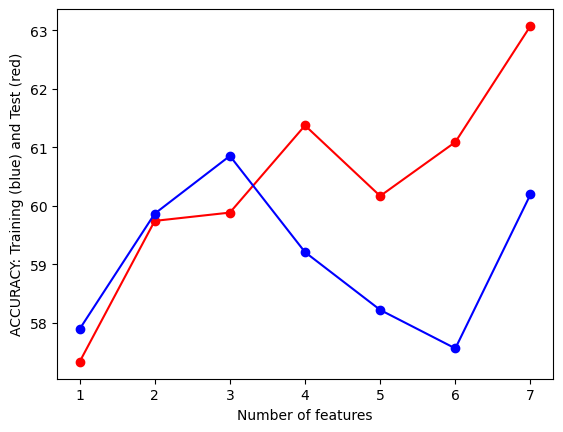

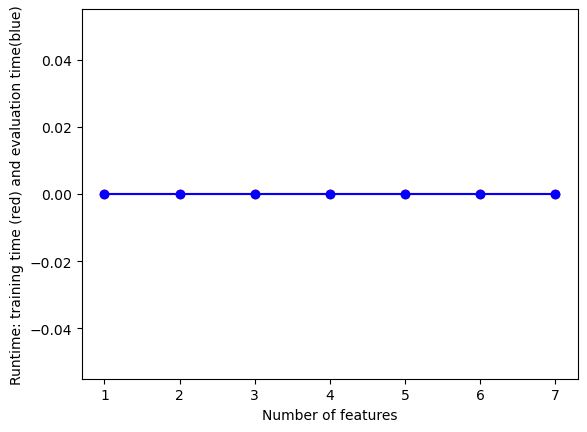

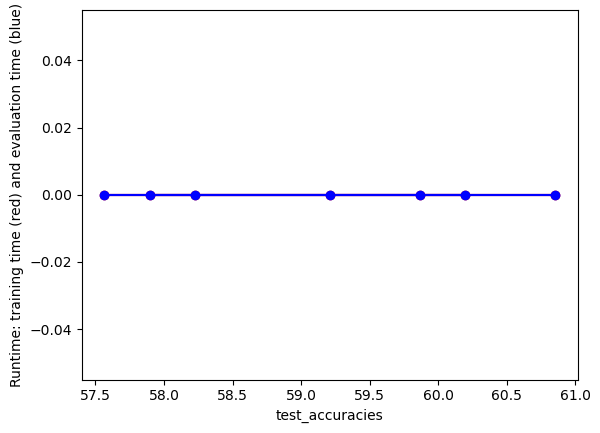

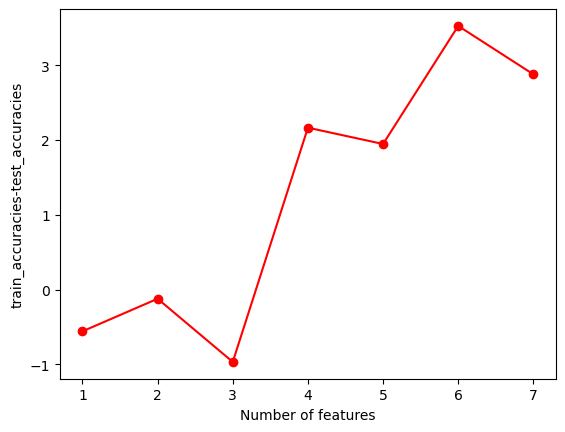

In [181]:
# More helper functions
import numpy as np
import matplotlib.pyplot as plt


def save_results_tab(path_root):
    out= np.transpose(np.array([num_features_tab,train_accuracies_tab,test_accuracies_tab,train_time_tab,eval_time_tab])) 
    out= pd.DataFrame(out)
    out.to_csv(path_root+"_tab.csv")



#UTILITY FUNCTION TO PLOT RESULTS
def plot_results_tab(path_root):

    #PLOT-1
    plt.plot(num_features_tab,train_accuracies_tab,'-or')
    plt.plot(num_features_tab,test_accuracies_tab,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('ACCURACY: Training (blue) and Test (red)')
    plt.savefig(path_root+'_tab-1.png')
    plt.show()

    # #PLOT-2
    plt.plot(num_features_tab,train_time_tab,'-or')
    plt.plot(num_features_tab,eval_time_tab,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('Runtime: training time (red) and evaluation time(blue)')
    plt.savefig(path_root+'_tab-2.png')
    plt.show()

    # #PLOT-3
    plt.plot(np.array(test_accuracies_tab),train_time_tab,'-or')
    plt.plot(np.array(test_accuracies_tab),eval_time_tab,'-ob')
    plt.xlabel('test_accuracies')
    plt.ylabel('Runtime: training time (red) and evaluation time (blue)')
    plt.savefig(path_root+'_tab-3.png')
    plt.show()

    # #PLOT-3
    plt.plot(num_features_tab,np.array(train_accuracies_tab)-np.array(test_accuracies_tab),'-or')
    plt.xlabel('Number of features')
    plt.ylabel('train_accuracies-test_accuracies')
    plt.savefig(path_root+'_tab-4.png')
    plt.show()


output_dir = "./"
save_results_tab(output_dir+"/partial_grid_search")
plot_results_tab(output_dir+"/partial_grid_search")

<h2> Feature selection for Text data </h2>

In [182]:
# now lets start removing features using code from the lab demo

def initialize_arrays():
    global num_features,train_accuracies
    global test_accuracies,train_time,eval_time
    num_features=[]
    train_accuracies=[]
    test_accuracies=[]
    train_time=[]
    eval_time=[]


# start arrays
initialize_arrays()

# DEFINE SEARCH FUNCTION
def partial_grid_search(num_runs, min_index, max_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i*int((max_index-min_index)/num_runs)
        
        # temp data
        xtraintemp =xtrn.iloc[:,0:upper_index]
        xtesttemp =xtst.iloc[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtraintemp, xtesttemp, ytrn, ytst, i_print=False)

        if(i%5==0):
            print(i,upper_index,xtraintemp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features.append(xtraintemp.shape[1])
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_time.append(time_train)
        eval_time.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=100, min_index=0, max_index= xtrn.shape[1])

# SPARSE SEARCH (LARGE NUMBER OF FEATURES (SLOWER))
#partial_grid_search(num_runs=20, min_index=1000, max_index=10000)

5 1770 1770 67.54075124025513 53.61842105263158
10 3540 3540 68.67469879518072 53.289473684210535
15 5310 5310 70.16300496102055 53.61842105263158
20 7080 7080 71.58043940467753 53.94736842105263
25 8850 8850 72.85613040396882 53.61842105263158
30 10620 10620 73.49397590361446 51.64473684210527
35 12390 12390 73.42310418143161 52.63157894736842
40 14160 14160 73.5648476257973 52.30263157894737
45 15930 15930 73.8483345145287 51.973684210526315
50 17700 17700 74.20269312544295 53.94736842105263
55 19470 19470 73.91920623671156 53.94736842105263
60 21240 21240 73.8483345145287 52.30263157894737
65 23010 23010 74.1318214032601 53.61842105263158
70 24780 24780 74.06094968107725 52.960526315789465
75 26550 26550 74.1318214032601 54.60526315789473
80 28320 28320 74.20269312544295 53.61842105263158
85 30090 30090 73.99007795889439 53.94736842105263
90 31860 31860 74.1318214032601 53.94736842105263
95 33630 33630 74.27356484762579 54.276315789473685
100 35400 35400 74.4153082919915 55.92105263

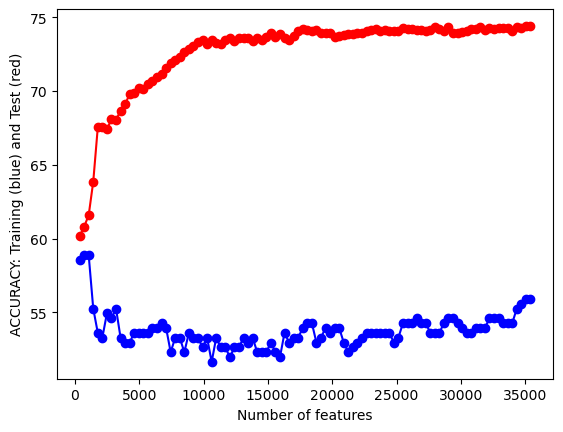

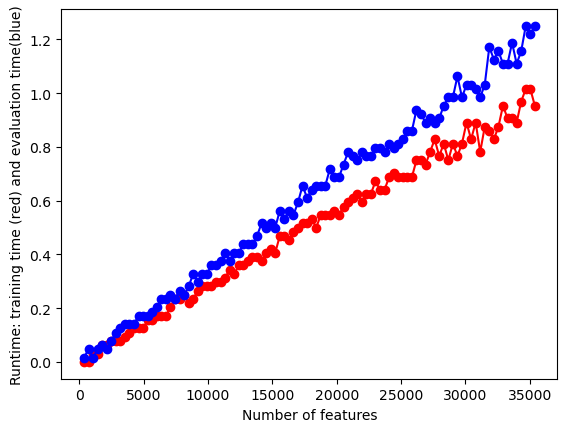

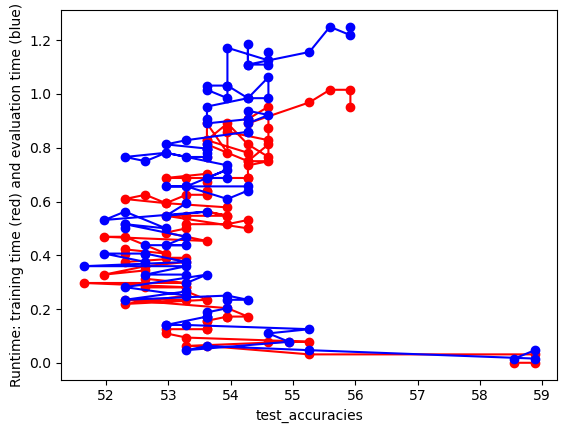

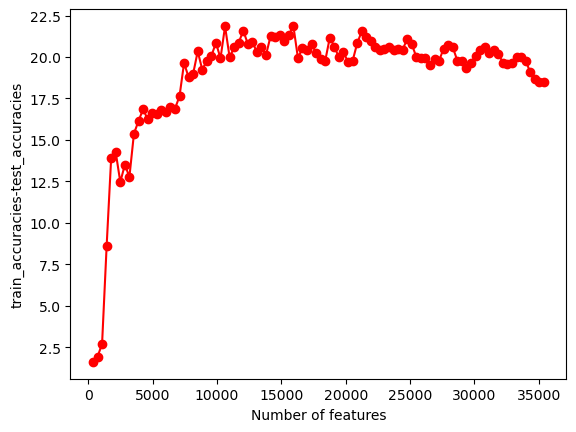

In [188]:
# More helper functions
import numpy as np
import matplotlib.pyplot as plt

def save_results(path_root):
    out= np.transpose(np.array([num_features,train_accuracies,test_accuracies,train_time,eval_time])) 
    out= pd.DataFrame(out)
    out.to_csv(path_root+".csv")



#UTILITY FUNCTION TO PLOT RESULTS
def plot_results(path_root):

    #PLOT-1
    plt.plot(num_features,train_accuracies,'-or')
    plt.plot(num_features,test_accuracies,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('ACCURACY: Training (blue) and Test (red)')
    plt.savefig(path_root+'-1.png')
    plt.show()

    # #PLOT-2
    plt.plot(num_features,train_time,'-or')
    plt.plot(num_features,eval_time,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('Runtime: training time (red) and evaluation time(blue)')
    plt.savefig(path_root+'-2.png')
    plt.show()

    # #PLOT-3
    plt.plot(np.array(test_accuracies),train_time,'-or')
    plt.plot(np.array(test_accuracies),eval_time,'-ob')
    plt.xlabel('test_accuracies')
    plt.ylabel('Runtime: training time (red) and evaluation time (blue)')
    plt.savefig(path_root+'-3.png')
    plt.show()

    # #PLOT-3
    plt.plot(num_features,np.array(train_accuracies)-np.array(test_accuracies),'-or')
    plt.xlabel('Number of features')
    plt.ylabel('train_accuracies-test_accuracies')
    plt.savefig(path_root+'-4.png')
    plt.show()


output_dir = "./"
save_results(output_dir+"/partial_grid_search")
plot_results(output_dir+"/partial_grid_search")

<h2> Naive Bayes with Labeled Record Data </h2>

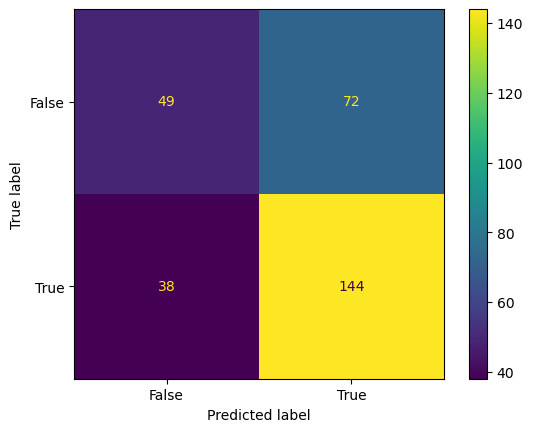

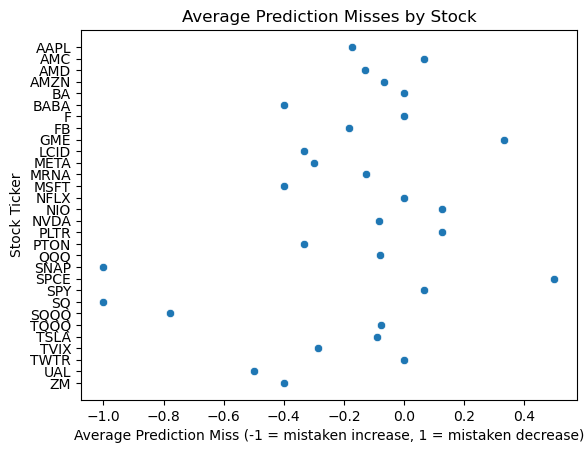

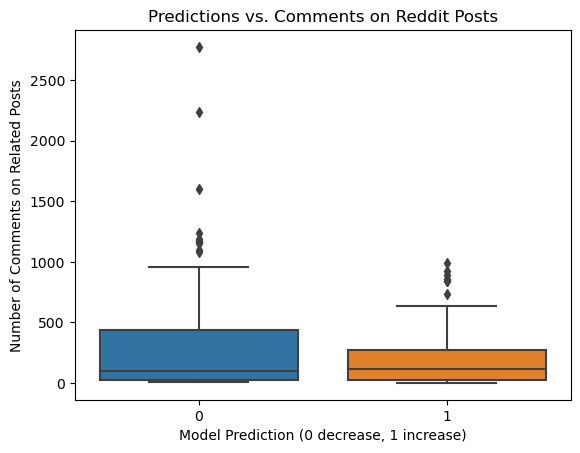

In [215]:
# Based on previous section, using all 8 features is ideal
#  fit model finally, report on overall accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

realTabModel = GaussianNB()
realTabModel.fit(xtabtrn, ytrn)

realTabTestPreds = realTabModel.predict(xtabreal)

confusion_matrix = metrics.confusion_matrix(yrl.values, realTabTestPreds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

tabOutcomeData = pd.DataFrame.from_dict( {'ticker': test['ticker'], 'comments': xtabreal['comments'], 'real value': yrl.values, 'predicted value': realTabTestPreds, "miss": yrl.values - realTabTestPreds} )

sns.scatterplot(data=tabOutcomeData.groupby(['ticker'])['miss'].mean().to_frame(), x = 'miss', y = 'ticker')
plt.xlabel('Average Prediction Miss (-1 = mistaken increase, 1 = mistaken decrease)')
plt.ylabel('Stock Ticker')
plt.title('Average Prediction Misses by Stock')
plt.show()

sns.boxplot(data=tabOutcomeData, x = 'predicted value', y = 'comments')
plt.xlabel('Model Prediction (0 decrease, 1 increase)')
plt.ylabel('Number of Comments on Related Posts')
plt.title('Predictions vs. Comments on Reddit Posts')
plt.show()


The optimal model for the record data was the one that included all 7 predictors. I identified this in the feature selection plots using the elbow method, which showed that the increase in performance never leveled off as more tabular features were added. 

Then, I fit this model on the training data and used it to predict values in the test set, the results of which are pictured in the first image above, the confusion matrix. While I expected the model to perform worse on the test set, the overall accuracy score (~0.64) was similar to those observed in the training (~0.60) and validation (~0.63) sets. The model appears to have learned to be successful by predicting more 1's (or increases) than 0's (or decreases). This gave the model high sensitivity but low precision.

In terms of over and under fitting, I believe my model is currently underfit although it includes all available features, with poor performance over all. I do not believe the record data model has been over fit because it has similar performance in both the training and test sets, so it has low variance. Yet the model has high bias in both training and test sets, only capturing an accurate result 60% of the time, barely beating a coin toss. 

The projects findings will be documented in a final slideshow, which will polish up and abridge the work contained in this page.

In conclusion: A Gaussian Naive Bayes classifier performs moderately well at predicting whether a given stock in the top-10 rankings of retail trader activity will see an increase or decrease in activity on the next trading day. With only 7 input features (such as the sentiment of individual investors and the number of reddit comments on posts mentioning the stock), the model identifies increases or decreases correctly about 64% of the time. While this is an improvement over random chance, the model could certainly be improved. The model also shows some relationships between variables: Certain stocks were almost always predicted over-optimisticly, such as SNAP (Snapchat), which was a famous stock that retail investors were interested in but lost money on. The number of comments also appears to be negatively correlated to stock increases, with tickers that had more comments on related posts being less likely to have an increase predicted the next day.



<h2> Naive Bayes with Labeled Text Data </h2>

Using your optimal feature set from the previous section, fit a final “optimal” NB model for your Record data.
Report and comment on the findings. It is required that you create code, appropriate visualizations, result summaries, confusion matrices, etc
Describe how the trained model is tested on the testing dataset.
Discuss the evaluation metrics used to assess the performance of the Naive Bayes classifier (e.g., accuracy, precision, recall, F1-score).
Discuss the concepts of overfitting and under-fitting and whether your model is doing it.
Discuss the model’s performance in terms of accuracy and other relevant metrics.
Describe how the project findings will be documented and reported, including the format of reports or presentations.
e.g. what is the output that you generate. What does the output mean? What does it tell you about your data? Does your model do a good job of predicting your test data? Include and discuss relevant visualizations, results, the confusion matrices, etc .
Create and include a minimum of three visualizations for each case (text and record classification).
Write a conclusion paragraph interpreting the results. Note, this is not the same as a write-up of technical methodological details.

[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0
 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1
 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0
 0 0 1 1 1 1 1]
[1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0
 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1
 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1
 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1
 1 0 0 1 

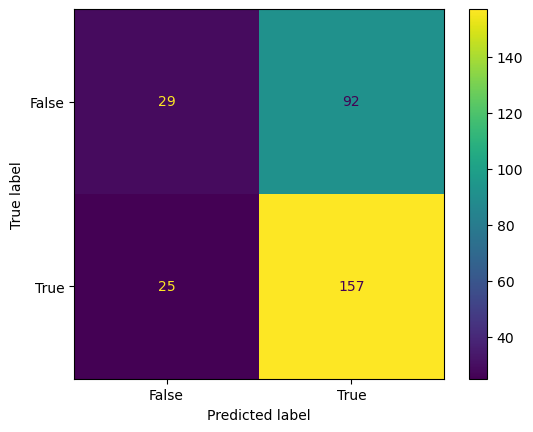

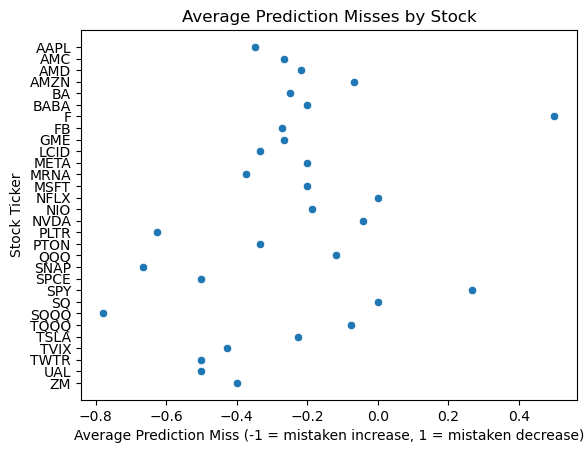

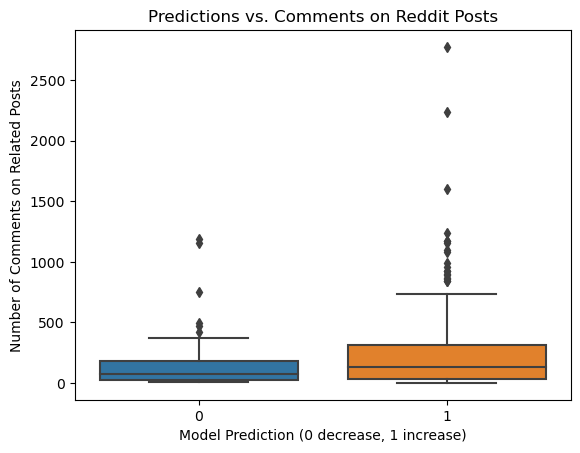

In [216]:
# fit model finally, report on overall accuracy
# based on the previous charts, we can use the elbow method for 

realModel = GaussianNB()
realModel.fit(xtrn.iloc[:,0:10000], ytrn)


realTestPreds = realModel.predict(xreal.iloc[:,0:10000])
print(realTestPreds)
print(yrl.values)

confusion_matrix = metrics.confusion_matrix(yrl.values, realTestPreds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

outcomeData = pd.DataFrame.from_dict( {'ticker': test['ticker'], 'comments': xreal['comments'], 'real value': yrl.values, 'predicted value': realTestPreds, "miss": yrl.values - realTestPreds} )

sns.scatterplot(data=outcomeData.groupby(['ticker'])['miss'].mean().to_frame(), x = 'miss', y = 'ticker')
plt.xlabel('Average Prediction Miss (-1 = mistaken increase, 1 = mistaken decrease)')
plt.ylabel('Stock Ticker')
plt.title('Average Prediction Misses by Stock')
plt.show()

sns.boxplot(data=outcomeData, x = 'predicted value', y = 'comments')
plt.xlabel('Model Prediction (0 decrease, 1 increase)')
plt.ylabel('Number of Comments on Related Posts')
plt.title('Predictions vs. Comments on Reddit Posts')
plt.show()

For the textual data Gaussian Naive Bayes classifier, it required more deduction to pick the correct number of features. This is because I began with about 35,000 columns in the dataset, due to the large number of unique words used in the reddit text corpus. However, using the elbow method, it appeared that the model's gains in performance peaked around the 10,000 feature mark. This number was also the point where the model reached its approximate peak in performance in the validation set, so I was curious to extend it to the test set and determine if it would continue to have low bias. 

As such, I fit this model on the training data and used it to predict values in the test set, the results of which are pictured in the first image above, the confusion matrix. Surprisingly, the far more comlicated model performed worse on the test set in terms of overall accuracy than the simple, 7-feature model (~0.61 instead of ~0.64). This performance was similar to those observed in the training (~0.60) and validation (~0.63) sets. Once again, the model appears to have learned to be successful by predicting more 1's (or increases) than 0's (or decreases). This gave the model high sensitivity but low precision.

In terms of over and under fitting, I believe the text data model model is still underfit, because it continues to have high bias and low variance across the training and test set. This is supported by the model's similar accuracy in both the training and test datasets. These findings will also be incorporated into a slideshow, along with, potentially, further work to tune the text data analysis.

In conclusion: A Gaussian Naive Bayes classifier trained on 1400 reddit posts performs moderately well at predicting whether a given stock in the top-10 rankings of retail trader activity will see an increase or decrease in activity on the next trading day. With 10,000 input features, the model identifies increases or decreases correctly about 61% of the time. While this is an improvement over random chance, the model could certainly be improved. As a point of interest, I included the same tabular data points in the text model as well, and found the relationships between the variables had changed. When accounting for textual data from reddit, the model begins to predict increases for stock tickers with a large number of comments in related posts. Further, the model's performance changed for particular stocks, with SNAP (Snapchat) no longer being tied with SQQQ for the most optimistic performance. Based on these results, it does not seem that reddit post texts contain a large amount of useful information for predicting retail investor actvity.